# Exploratory Data Analysis

## Load the transaction dataset

In [1]:
import pandas as pd
original=pd.read_csv('ANZ synthesised transaction dataset.csv')
state=59
data = original.sample(frac=0.8,random_state=state)  
test = original[original.index.isin(data.index)==False].copy() 
data=data.reset_index(drop=True)  
test=test.reset_index(drop=True)  
    
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook')
sns.set_style('white')
import statsmodels.formula.api as smf
import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')

## Data preparation

In [2]:
data.head().round(2)

,status,card_present_flag,bpay_biller_code,account,currency,long_lat,txn_description,merchant_id,merchant_code,first_name,...,age,merchant_suburb,merchant_state,extraction,amount,transaction_id,country,customer_id,merchant_long_lat,movement
0,authorized,0.0,NaN,ACC-1903037542,AUD,153.05 -27.61,SALES-POS,d879e353-647c-4c79-91c5-d5ec7bc13e7a,NaN,Jeffrey,...,30,Sunnybank,QLD,2018-10-02T16:31:53.000+0000,14.96,7b48ae7d962a429bad2ac8dbfd5a99df,Australia,CUS-860700529,153.06 -27.57,debit
1,posted,NaN,0,ACC-2173390920,AUD,144.71 -37.58,PAY/SALARY,NaN,0.0,Luis,...,27,NaN,NaN,2018-10-29T13:00:00.000+0000,1396.23,b3232af7aa424d669d611b9425601e3b,Australia,CUS-3180318393,NaN,credit
2,authorized,1.0,NaN,ACC-1349834573,AUD,145.17 -37.84,SALES-POS,2fc63504-5462-4673-8cf1-2614feb94cc4,NaN,Matthew,...,39,Doncaster,VIC,2018-08-08T20:27:13.000+0000,21.52,b5cd0d2e5f34405abdaa3253d5312ae2,Australia,CUS-1790886359,145.13 -37.78,debit
3,posted,NaN,NaN,ACC-90814749,AUD,151.68 -32.98,PAYMENT,NaN,NaN,Christopher,...,35,NaN,NaN,2018-10-18T22:00:00.000+0000,36.00,74f0a778b0514a1398f35c66e3dc145e,Australia,CUS-1896554896,NaN,debit
4,posted,NaN,NaN,ACC-2107684084,AUD,145.03 -37.88,PAYMENT,NaN,NaN,Richard,...,22,NaN,NaN,2018-10-10T10:00:00.000+0000,34.00,e4ae1f6e86b441d89033871607140937,Australia,CUS-2283904812,NaN,debit


In [3]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
card_present_flag,6179.0,0.800453,0.399692,0.00,1.000,1.000,1.0000,1.00
merchant_code,688.0,0.000000,0.000000,0.00,0.000,0.000,0.0000,0.00
balance,9634.0,14780.936020,31596.984625,0.25,3161.045,6507.225,12521.4725,267128.52
age,9634.0,30.533423,9.989924,18.00,22.000,28.000,38.0000,78.00
amount,9634.0,185.709113,583.315346,0.10,16.000,28.730,53.0000,8835.98


In [4]:
#change the format of data column and identify the weekdays
data['date'] = pd.to_datetime(data.date)
data['weekday']=data['date'].dt.weekday
data['date']=data['date'].dt.strftime('%m/%d/%Y')

#derive weekday and hour data of each transaction
import datetime
data['hour']=data['extraction'].str.slice(11,19)
data['hour']=pd.to_datetime(data.hour)
data['hour']=data['hour'].dt.strftime('%H')

#split the latitude and longtitude of both customers and merchants for further analysis
c_loc = data['long_lat'].str.split(" ", n = 1, expand = True) 
data['c_long']=c_loc[0].astype(float)
data['c_lat']=c_loc[1].astype(float)
m_loc = data['merchant_long_lat'].str.split(" ", n = 1, expand = True) 
data['m_long']=m_loc[0].astype(float)
data['m_lat']=m_loc[1].astype(float)

#filter out transactions for those who do not reside within Australia
data_new=data[(data['c_long'] >113) & (data['c_long'] <154) & (data['c_lat'] > (-44)) & (data['c_lat'] < (-10))]

## Overall insights about data

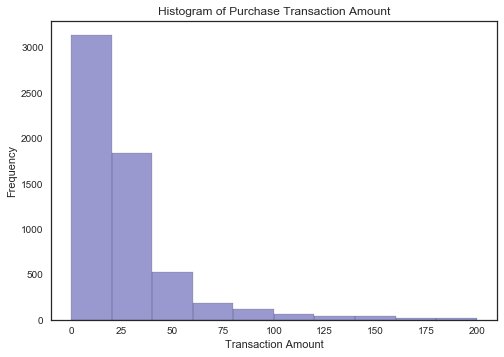

In [5]:
#filter out purchase transactions only
#assuming purchase transactions must be associated with a merchant (have a merchant Id)
data_temp = data_new[data.merchant_id.notnull()]
data_temp.describe()

#visualise the purchase transaction amount
plt.hist(data_temp['amount'], range=[0,200],alpha=0.4,edgecolor='black',color='darkblue')
plt.ylabel('Frequency')
plt.xlabel('Transaction Amount')
plt.title('Histogram of Purchase Transaction Amount')
plt.style.use('ggplot')
plt.show()

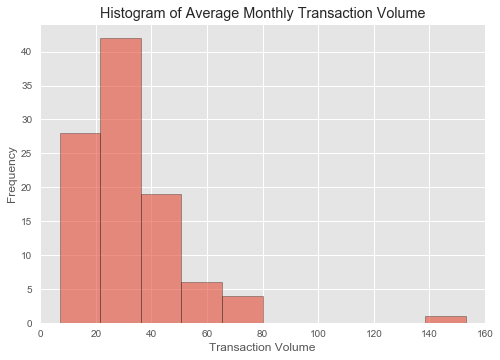

In [6]:
#visualise customers' average monthly transaction volume
data_temp1=data.groupby('customer_id').count()[['transaction_id']]
data_temp1['average monthly transaction volume']=(data_temp1['transaction_id']/3).round()
plt.hist(data_temp1['average monthly transaction volume'],alpha=0.6,edgecolor='black')
plt.ylabel('Frequency')
plt.xlabel('Transaction Volume')
plt.title('Histogram of Average Monthly Transaction Volume')
plt.style.use('ggplot')
plt.show()

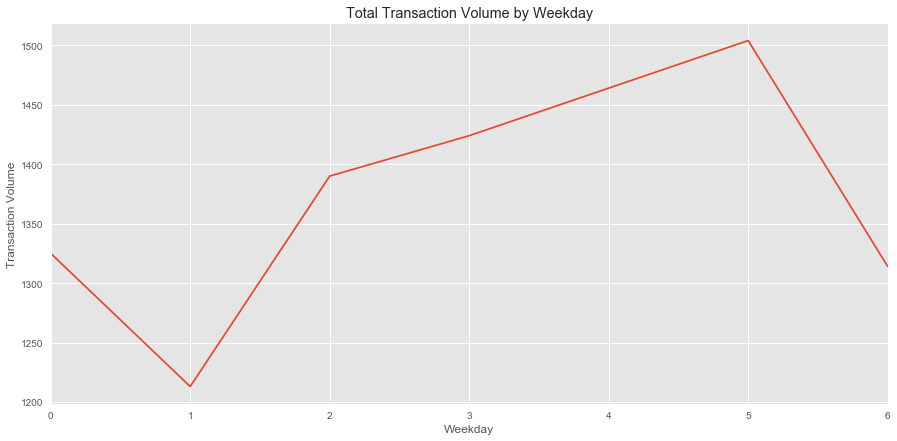

In [7]:
# Visualise transaction volume by weekday
fig, ax = plt.subplots(figsize=(15,7))
data.groupby(['weekday']).count()['transaction_id'].plot(ax=ax)
plt.ylabel('Transaction Volume')
plt.xlabel('Weekday')
plt.title('Total Transaction Volume by Weekday')
plt.style.use('ggplot')
plt.show()

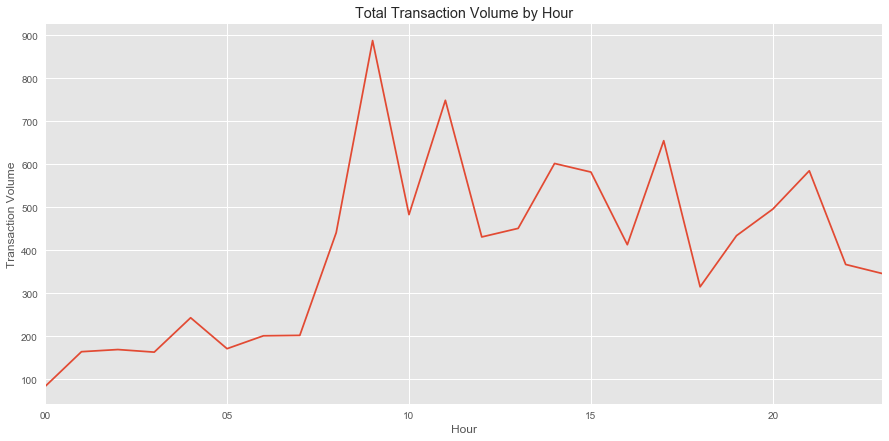

In [8]:
# Visualise transaction volume by hour
fig, ax = plt.subplots(figsize=(15,7))
data.groupby(['hour']).count()['transaction_id'].plot(ax=ax,)
plt.ylabel('Transaction Volume')
plt.xlabel('Hour')
plt.title('Total Transaction Volume by Hour')
plt.style.use('ggplot')
plt.show()

# Predictive Modelling

In [9]:
# Calculate the annual salary
data_new=data[data['txn_description'] =='PAY/SALARY']
salary_by_customer=data_new.groupby(['customer_id']).sum()['amount'].reset_index(name='salary')
salary_by_customer['annual_salary']=(salary_by_customer['salary'])*4

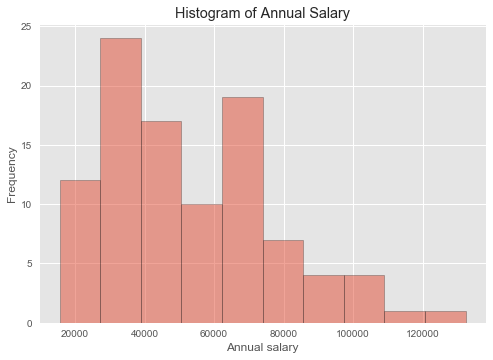

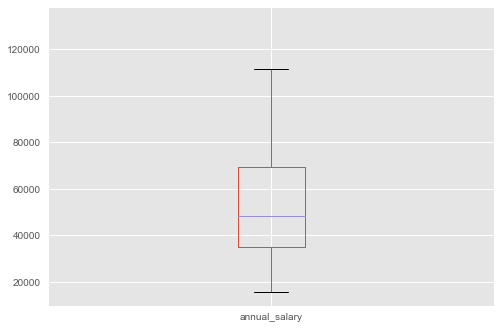

In [10]:
#visualise the distribution of annual salary
ax=fig.add_subplot(121)
salary_by_customer['annual_salary'].hist(alpha=0.5,edgecolor='black')
plt.ylabel('Frequency')
plt.xlabel('Annual salary')
plt.title('Histogram of Annual Salary')
plt.show()
ax=fig.add_subplot(122)
salary_by_customer['annual_salary'].plot(kind='box')
plt.show()

## Correlation between annual salary and other variables

In [11]:
#join tables
balance=data_new.groupby(['customer_id']).mean()['balance'].reset_index(name='average_balance')
analysis=salary_by_customer.merge(balance, on='customer_id', how='left')
analysis= pd.merge(analysis,data_new[['customer_id','gender','age']],on='customer_id', how='inner')
analysis.drop_duplicates(subset ="customer_id",keep = 'first', inplace = True)
#convert gender into numerical values
gender = []
for row in analysis['gender']:
    if row =='F': 
        gender.append(0)
    else:           
        gender.append(1)
analysis['gender_no'] = gender

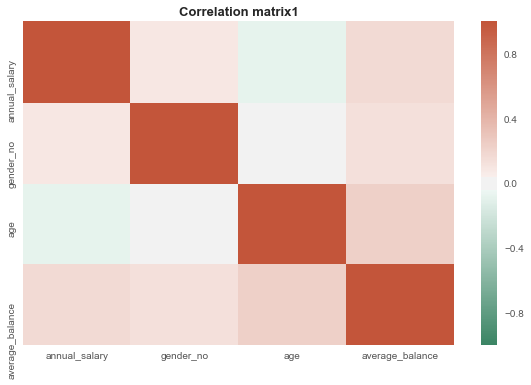

In [12]:
#calculate correlation
response=['annual_salary']
gender_no=['gender_no']
age=['age']
average_balance=['average_balance']

fig, ax = plt.subplots()
cmap = sns.diverging_palette(150, 20, as_cmap=True)
sns.heatmap(analysis[response+gender_no+age+average_balance].corr(), ax=ax, cmap=cmap)
ax.set_title('Correlation matrix1', fontweight='bold', fontsize=13)
plt.tight_layout()
plt.show()

In [13]:
analysis[response+gender_no+age+average_balance].corr().round(2)

,annual_salary,gender_no,age,average_balance
annual_salary,1.00,0.09,-0.08,0.17
gender_no,0.09,1.00,0.00,0.13
age,-0.08,0.00,1.00,0.23
average_balance,0.17,0.13,0.23,1.00


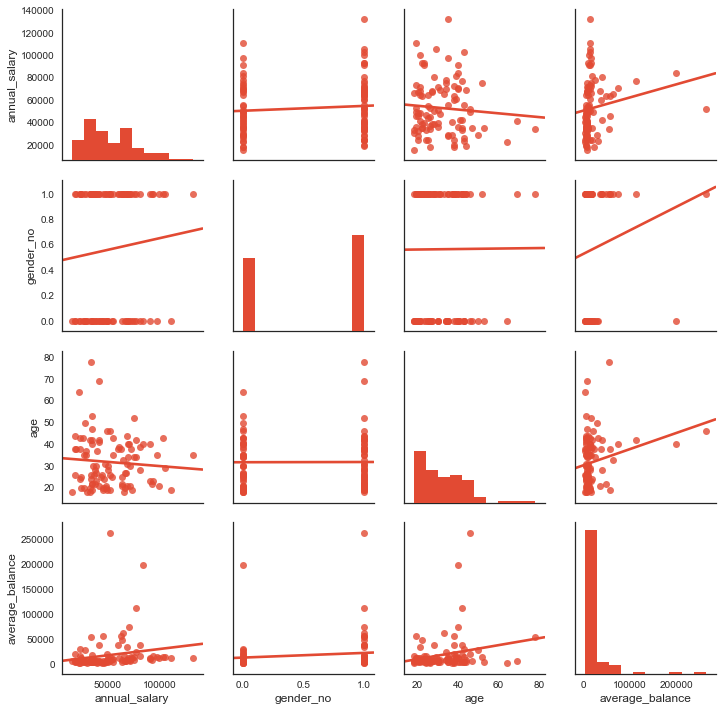

In [14]:
with sns.axes_style('white'):
    sns.pairplot(analysis[response+gender_no+age+average_balance], kind='reg', plot_kws={'ci':None})
plt.show()

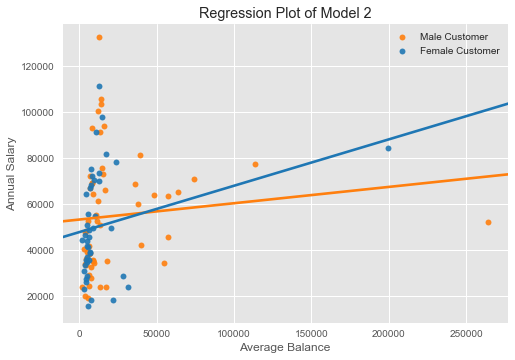

In [15]:
# vidualisa the relationship between gender and annual salary
tableau=['#1F77B4', '#FF7F0E'] # blue and orange are constrast colors, easier to see than the default blue and green

fig, ax= plt.subplots()

index=analysis['gender_no']==1
sns.regplot(analysis.loc[index, 'average_balance'], analysis.loc[index,  'annual_salary'], label='Male Customer',
             ci=None, color=tableau[1], scatter_kws={'s': 35, 'color': tableau[1], 'alpha': 0.9})

index=analysis['gender_no']==0
sns.regplot(analysis.loc[index, 'average_balance'], analysis.loc[index, 'annual_salary'], label='Female Customer',
             ci=None, color=tableau[0], scatter_kws={'s': 35, 'color': tableau[0], 'alpha': 0.9})

ax.set_xlabel('Average Balance',  {'fontsize': 12})
ax.set_ylabel('Annual Salary', {'fontsize': 12})
ax.set_title('Regression Plot of Model 2')

sns.despine()
plt.legend()
sns.plt.show()

## Linear Regression

In [16]:
analysis.reset_index(drop=True)
reg1 = smf.ols('annual_salary ~ average_balance', data=analysis).fit()
print(reg1.summary())

                            OLS Regression Results                            
Dep. Variable:          annual_salary   R-squared:                       0.029
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     2.945
Date:                Wed, 01 Jul 2020   Prob (F-statistic):             0.0894
Time:                        15:28:00   Log-Likelihood:                -1137.8
No. Observations:                  99   AIC:                             2280.
Df Residuals:                      97   BIC:                             2285.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
Intercept        5.083e+04   2729.318     

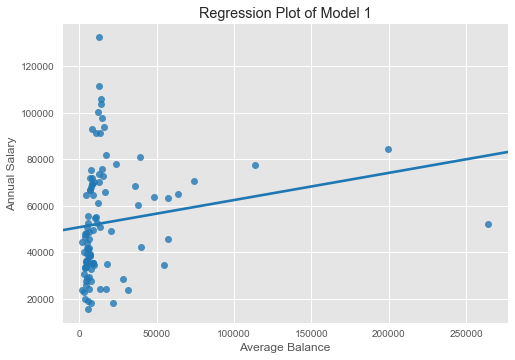

In [17]:
ffig, ax=plt.subplots()  
sns.regplot(analysis['average_balance'],analysis['annual_salary'], ci=None,color=tableau[0]) #Linear-Linear  
sns.despine()   
ax.set_xlabel('Average Balance')  
ax.set_ylabel('Annual Salary')  
ax.set_title('Regression Plot of Model 1')  
plt.show()


In [18]:
analysis.reset_index(drop=True)
reg2 = smf.ols('annual_salary ~ average_balance+C(gender_no)', data=analysis).fit()
print(reg2.summary())

                            OLS Regression Results                            
Dep. Variable:          annual_salary   R-squared:                       0.034
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     1.689
Date:                Wed, 01 Jul 2020   Prob (F-statistic):              0.190
Time:                        15:28:01   Log-Likelihood:                -1137.6
No. Observations:                  99   AIC:                             2281.
Df Residuals:                      96   BIC:                             2289.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------
Intercept          4.908e+04   3781.42

## Log Regression

In [19]:
analysis.reset_index(drop=True)
reg1 = smf.ols('annual_salary ~ np.log(average_balance)', data=analysis).fit()
print(reg1.summary())

                            OLS Regression Results                            
Dep. Variable:          annual_salary   R-squared:                       0.130
Model:                            OLS   Adj. R-squared:                  0.121
Method:                 Least Squares   F-statistic:                     14.53
Date:                Wed, 01 Jul 2020   Prob (F-statistic):           0.000242
Time:                        15:28:01   Log-Likelihood:                -1132.4
No. Observations:                  99   AIC:                             2269.
Df Residuals:                      97   BIC:                             2274.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------------
Intercept               -3

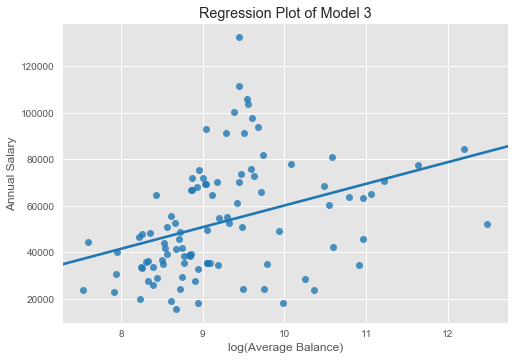

In [20]:
#analysis['LogBalance']=np.power(analysis['average_balance'])
ffig, ax=plt.subplots()  
sns.regplot(np.log(analysis['average_balance']),analysis['annual_salary'], ci=None,color=tableau[0]) #Linear-Linear  
sns.despine()   
ax.set_xlabel('log(Average Balance)')  
ax.set_ylabel('Annual Salary')  
ax.set_title('Regression Plot of Model 3')  
plt.show()

## Polynomial Regression

In [36]:
analysis.reset_index(drop=True)
reg4 = smf.ols('annual_salary ~ average_balance+np.power(average_balance,2)+np.power(average_balance,3)', data=analysis).fit()
print(reg4.summary())

                            OLS Regression Results                            
Dep. Variable:          annual_salary   R-squared:                      -1.139
Model:                            OLS   Adj. R-squared:                 -1.184
Method:                 Least Squares   F-statistic:                    -25.56
Date:                Wed, 01 Jul 2020   Prob (F-statistic):               1.00
Time:                        16:04:41   Log-Likelihood:                -1176.9
No. Observations:                  99   AIC:                             2360.
Df Residuals:                      96   BIC:                             2368.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------------------
Intercept       

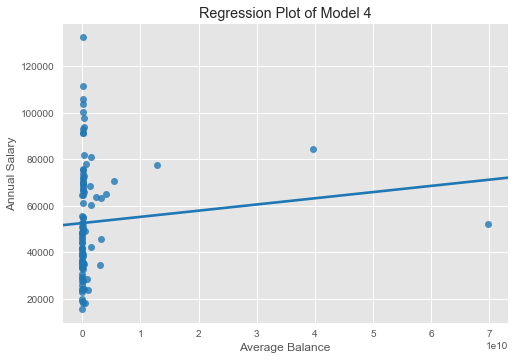

In [35]:
#analysis['LogBalance']=np.power(analysis['average_balance'])
ffig, ax=plt.subplots()  
sns.regplot(np.power(analysis['average_balance'],2),analysis['annual_salary'], ci=None,color=tableau[0]) 
sns.despine()   
ax.set_xlabel('Average Balance^2')  
ax.set_ylabel('Annual Salary')  
ax.set_title('Regression Plot of Model 4')  
plt.show()

## Assumption Validation

In [ ]:
residuals=reg3.resid
from matplotlib import gridspec

fig = plt.figure(figsize=(13, 10)) 
gs = gridspec.GridSpec(2, 4) 
ax1 = plt.subplot(gs[0,:2])
ax2 = plt.subplot(gs[0,2:])
ax3 = plt.subplot(gs[1,1:3])

sns.distplot(residuals, ax=ax1, hist_kws={'alpha': 0.6, 'edgecolor':'black','color':sns.color_palette()[1]}, kde_kws={'color': 'black', 'alpha': 0.4})
ax1.set_title('Residual histogram', fontsize=12)


sns.boxplot(residuals, orient='h',color=sns.color_palette()[1], saturation=0.95,ax=ax2)
ax2.set_title('Box plot for the residuals', fontsize=12)
              
pp = sm.ProbPlot(residuals, fit=True)
qq = pp.qqplot(color=sns.color_palette()[1], alpha=0.6, ax=ax3)
a=ax3.get_xlim()[0]
b=ax3.get_xlim()[1]
ax3.plot([a,b],[a,b], color='black', alpha=0.4)
ax3.set_xlim(a,b)
ax3.set_title('Normal Q-Q plot for the residuals', fontsize=12)


plt.tight_layout()
plt.show()

## Predictive Modelling

In [ ]:
# Calculate the annual salary for the test data
test_new=test[test['txn_description'] =='PAY/SALARY']
salary_by_customer_test=test_new.groupby(['customer_id']).sum()['amount'].reset_index(name='salary')
salary_by_customer_test['annual_salary']=(salary_by_customer_test['salary'])*4

#join tables
balance_test=test_new.groupby(['customer_id']).mean()['balance'].reset_index(name='average_balance')
analysis_test=salary_by_customer_test.merge(balance_test, on='customer_id', how='left')
analysis_test= pd.merge(analysis_test,test_new[['customer_id','gender','age']],on='customer_id', how='inner')
analysis_test.drop_duplicates(subset ="customer_id",keep = 'first', inplace = True)

In [ ]:
pred=reg3.predict(analysis_test)  
e1=analysis_test['annual_salary']-pred  
print(round(np.mean(e1**2),1)) #MSE  
print(round(1-np.mean(e1**2)/analysis_test['annual_salary'].var(), 3)) #R square  
m1=np.abs(e1)  
print(round(np.mean(m1),1)) # MAE  
analysis_test['Prediction Error Under Log Model']=e1  
analysis_test['Actual Value']=analysis_test['annual_salary']  
analysis_test.plot(kind='scatter', x='Actual Value', y='Prediction Error Under Log Model',title='Actual Value vs Prediction Error Under Model 3',alpha=0.8, color=sns.color_palette()[1])  
plt.show()  